In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import networkx as nx
import random
import matplotlib.pyplot as plt
import sys

In [8]:
def generate_random_connected_graph(num_nodes, background_density, background_weight, return_flexible_edges = False):
    tree_base = nx.random_tree(n = num_nodes)
    G = tree_base
    
    num_edges_to_add = int(num_nodes*(num_nodes - 1)*0.5*background_density - (num_nodes - 1))
    #pick num_edges_to_add random edges to add to G
    flexible_edge_list = random.sample(list(nx.non_edges(G)), num_edges_to_add)
    G.add_edges_from(flexible_edge_list)
    nx.set_edge_attributes(G, values = background_weight, name = 'weight')
    
    assert(nx.is_connected(G)) 
    if (return_flexible_edges): 
        return (G, flexible_edge_list)
    else:
        return G

In [9]:
def find_paths(G, source_node, length, excludeSet = None):
    if excludeSet == None:
        excludeSet = set([source_node])
    else:
        excludeSet.add(source_node)
    if length==0:
        return [[source_node]]
    paths = [[source_node] + path for neighbor in G.neighbors(source_node) if neighbor not in excludeSet for path in find_paths(G,neighbor,length-1,excludeSet)]
    excludeSet.remove(source_node)
    return paths


In [10]:
#utility functions

def choose_S_path(G, num_S):
    all_candidates = []
    for node in G:
        all_candidates.extend(find_paths(G, node, num_S-1))
    result = random.choice(all_candidates)
    return result

def path_compare(path1, path2):
    assert( len(path1) == len(path2) )
    for c1, c2 in zip(path1, path2):
        if (c1 != c2):
            return False
    return True


In [11]:
def construct_test_case(G_num_nodes, G_density, G_background_weight, S_num_nodes, S_weight):
    G1 = generate_random_connected_graph(G_num_nodes, G_density, G_background_weight)
    G2, flexible_edges = generate_random_connected_graph(G_num_nodes, G_density, G_background_weight, return_flexible_edges = True)
    
    S = choose_S_path(G1, S_num_nodes)
    S_path_graph = nx.path_graph(S)
    
    filtered_edges = []
    for (a,b) in flexible_edges:
        if (a,b) in S_path_graph.edges():
            pass
        else:
            filtered_edges.append((a,b))
    flexible_edges= filtered_edges
    
    weight_dict = {e:S_weight for e in S_path_graph.edges()}
    for u, v in S_path_graph.edges():
        G1[u][v]['weight'] = S_weight 
        if ((u,v) not in G2.edges()):
            G2.add_edge(u, v)
            (a,b) = random.choice(flexible_edges)
            G2.remove_edge(a,b)
            flexible_edges.remove((a,b))
            G2[u][v]['weight'] = S_weight
    
    return (G1, G2, S)

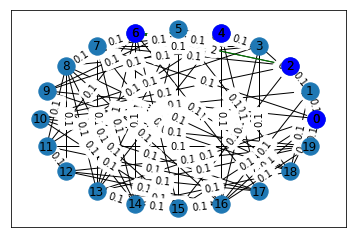

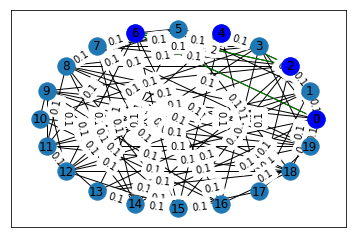

In [14]:
(G1, G2, S) = construct_test_case(G_num_nodes=20, G_density=0.4, G_background_weight=0.1, S_num_nodes=4, S_weight=2)

edge_weights = nx.get_edge_attributes(G1,'weight')


adj_G1 = nx.to_pandas_adjacency(G1)
adj_G2 = nx.to_pandas_adjacency(G2)
adj_G1.to_csv(path_or_buf='adj_G1.csv',index=False)
adj_G2.to_csv(path_or_buf='adj_G2.csv',index=False)
with open('S.txt', 'w') as f:
    S_string = ', '.join([str(item) for item in S])
    f.write(S_string)

pos=nx.circular_layout(G1)
nx.draw_networkx(G1, pos=pos)
nx.draw_networkx(nx.induced_subgraph(G1, S), pos=pos, node_color = 'blue', edge_color = 'green')
nx.draw_networkx_edge_labels(G1, pos, edge_labels = edge_weights)
plt.show()

pos=nx.circular_layout(G2)
nx.draw_networkx(G2, pos=pos)
nx.draw_networkx(nx.induced_subgraph(G2, S), pos=pos, node_color = 'blue', edge_color = 'green')
nx.draw_networkx_edge_labels(G2, pos, edge_labels = edge_weights)
plt.show()



In [ ]:
import os

ctd_run_command = "docker run -v $(PWD):/mnt vladimirkovacevic/ctd:1.4 Rscript /opt/CTD/R/CTD.r --experimental /mnt/experimental.csv --control /mnt/control.csv --output_name /mnt/output.json"

os.system(ctd_run_command)